In [1]:
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os

Ejercicio 2: Delfines

In [5]:
# Leemos el archivo
myFolder=(os.getcwd()+'/tc01_data/') #busca en el directorio actual

# Primero creamos la red de delfines. Agregando los enlaces se agregan automaticamente los nodos
mydolphins = nx.read_gml(myFolder+'new_dolphins.gml')

# Ahora creamos dos listas: una de nombres de delfines (nodos) y otra de los generos correspondientes
Gender = pd.read_csv(myFolder+'dolphinsGender.txt', sep='\t', header=None)
delfines = Gender[0] # nombres de delfines (nodos)
genero = Gender[1]   # genero de los delfines

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    mydolphins.add_node(d, gender=g)
    

#print mydolphins.nodes['Jet']['gender'] Para ver la prop genero en el delfin 'Jet'


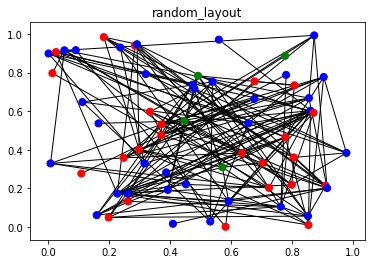

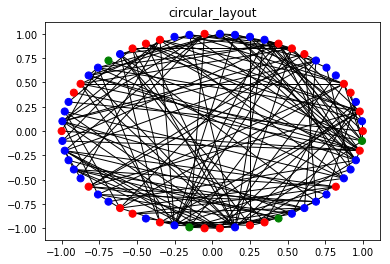

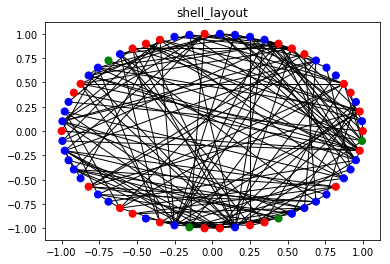

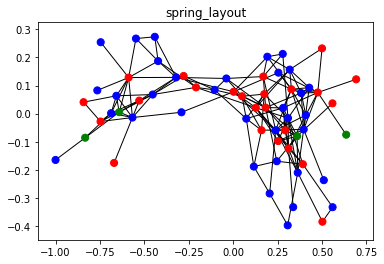

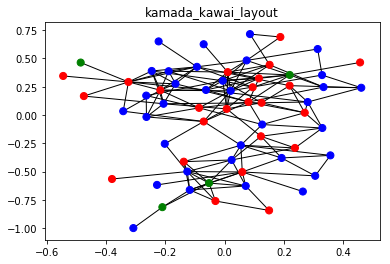

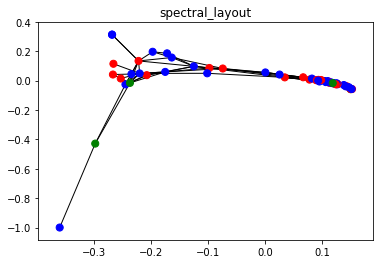

In [11]:
#a) Tipos de Layout

layouts=['random_layout','circular_layout','shell_layout','spring_layout','kamada_kawai_layout','spectral_layout']
# fruchterman reingold es el algoritmo que usa spring

for f,lay in enumerate(layouts):
 plt.figure(f)
 nx.draw_networkx(mydolphins,eval('nx.'+lay)(mydolphins),
        width=1,
        node_color=["blue" if g=="m" else "red" if g=="f" else "green" for g in nx.get_node_attributes(mydolphins, "gender").values()], 
        node_size=50,
        with_labels=False
       )
 plt.title(lay)
plt.show()



In [ ]:
#b)Analisis de la homofilia
Enlaces_fm=[]

#Hacemos 3000 asignaciones aleatorias de genero:
for it in range(0,3000):

    #Reordenamos el vector de generos
    if it==0:
        genero_shuffle=genero #No lo reordenamos si es el primero de la red real
    else:
        genero_shuffle=genero
        np.random.shuffle((genero_shuffle)) #Reordenamos aleat los generos si no es el primero

    #Reasignamos a cada nodo un valor en el vector de genero_shuffle:
    for d,g in zip(delfines,genero_shuffle):
        mydolphins.add_node(d, gender=g)
        
    #Contamos la fraccion de enlaces que conecta nodos con diferente genero o sea f-m:
    enlaces=list(mydolphins.edges.data())
    enlaces_fm=0 #Ponemos en cero el contador
    #Recorremos los enlaces y nos fijamos cual de ellos es del tipo f-m:
    for i in range(0,len(enlaces)-1):
        genero1=mydolphins.nodes[enlaces[i][0]]['gender']
        genero2=mydolphins.nodes[enlaces[i][1]]['gender']
        if genero1 != genero2:   #Comparamos los generos
         enlaces_fm=enlaces_fm+1 #Incrementamos el contador si el enlace es f-m
    Enlaces_fm.append(float(enlaces_fm)/(mydolphins.number_of_edges())) #Guardamos la fraccion de enlaces f-m

#Valor medio y desviacion standar
mean_enlacesfm=np.mean(Enlaces_fm)
desv_enlacesfm=np.std(Enlaces_fm)

print 'Distribucion de enlaces fm:'
print 'Valor medio {}'.format(mean_enlacesfm)
print 'Desviacion Standar {}'.format(desv_enlacesfm)
print 'Red Real {}'.format(Enlaces_fm[0])
  
#Histograma:
plt.hist(Enlaces_fm, bins=15,edgecolor='black', linewidth=1.2,label='Hnull',density=True)
plt.axvline(Enlaces_fm[0], c="red",label='Red real')#Linea vertical en el valor de la red real
plt.xlabel('Fraccion de enlaces fm')
plt.ylabel('Cuenta')
plt.title('Red de Delfines-Analisis de homofilia')
plt.legend()
plt.show() 

